<a id='beginning_CRVA'></a>
# Climate Risk and Vulnerability Analysis
This notebook helps you download and visualize climate data to perform Climate Risk and Vulnerability analyses

WARNING: IF RUNNING FROM THE SERVER YOU FIRST NEED TO CHANGE THE KERNEL TO "Python [conda env:root]"

## Usage
this is how to use this script

1. [Define user input](#user_input)
2. [Run wanted climate variables](#climate_variables)
    1. [Atmosphere's climate variables](#atmosphere_climate_variables)
    2. [Land climate's variables](#land_climate_variables)
    3. [Hydrosphere's climate variables](#hydrosphere_climate_variables)
    4. [Second effect's climate variables](#second_effect_climate_variables)
3. [Export data](#Export)

## Input data

* [Shapefile with project location(s) as points or polygon](#load_shapefile)
* List of variables
* List of SSP's
* List of time horizons

## [Climate variables](#climate_variables)
### [Atmosphere's climate variables](#atmosphere_climate_variables)
* [precipitation](#worldbank)
* [temperature](#worldbank)
### [Land's climate variables](#land_climate_variables)
* [landslides](#landslides)
### [Hydrosphere's climate variables](#hydrosphere_climate_variables)
* water availability
* floods (fluvial)
* floods (coastal)
* forest fires
### [Second effects of climate variables](#second_effect_climate_variables)
* [cyclone risk](#cyclone_risk)



* earthquakes (not climate related)

## Climate impacts
* calculate impact on yields

## [Climate change information concerning the projects in the study area](#climate_change_info_for_each_project_in_study_area)


## Contact

rapy@cowi.com


<a id='user_input'></a>
## User inputs

[Home](#beginning_CRVA)

In [26]:
#User inputs
import os.path


#project locations (shapefile with location of elements to evaluate)
data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
data_folder=os.path.join(os.pardir,'dataset')
project_location_path=os.path.join(data_folder,'Mozambique_PPIS/EIB_locations_few.shp')
project_id='Name' #name of column used as id

#study boundary (optional)
study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')

#output folder
#out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Scripts\outputs'
out_path='outputs'

#projection CRS (default = 'EPSG:4326')
bCRS='EPSG:4326'

#buffer for climate/grid variables
buffer=40000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:31983' #metric CRS for buffer in meters (find relevant metric CRS for location!)

## Import python packages

In [27]:
#Import python packages
from rasterstats import zonal_stats
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import rioxarray #used when calling ncdata.rio.write_crs
import xarray
import os
import matplotlib.pyplot as plt
import netCDF4 as nc#not directly used but needs to be imported for some nc4 files manipulations, use for nc files
from netCDF4 import Dataset
import csv #REMOVE ? not in use ?
import numpy as np
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
#import numpy as np
#import io

## Import functions
### read_cckp_ncdata

In [28]:
#def read cckp (world bank) nc files
#reads data from world bank climate knowledge portal, nc files, with a single band
#assigns projection and exports to tif since zonal_stats seems to have issues with it otherwise (not ideal solution)
def read_cckp_ncdata(nc_path,output='tempfile.tif'):
    with rioxarray.open_rasterio(nc_path,decode_times=False)[0] as ncdata:
        ncdata.rio.write_crs('EPSG:4326', inplace=True)
        ncdata=ncdata.isel(time=0)
        ncdata.rio.to_raster(output)
       # output=output #here
   # else: 
      #  print(nc_path,"not found") # in this case, the data printed in the table will apply to the previous print.. 
       # output=0 #here
    return output       

#def read nc files (copernicus)
#reads data from CMIP6 Copernicus, nc files
#assigns projection and exports to tif since zonal_stats seems to have issues with it otherwise (not ideal solution)
def read_nc_data(nc_path,stats,output='tempfile.tif'):
    with rioxarray.open_rasterio(nc_path,decode_times=False)[3] as ncdata:
        # calculate statistiques for each variable
        if stats == 'mean':
            ncdata=ncdata.mean(dim='time')
        elif stats == 'median':
            ncdata=ncdata.median(dim='time')
        elif stats == 'p10':
            ncdata=ncdata.quantile(0.1, dim='time')
        elif stats == 'p90':
            ncdata=ncdata.quantile(0.9, dim='time')
        
        ncdata.rio.write_crs('EPSG:4326', inplace=True)
        ncdata.rio.to_raster(output)
    return output       

### get_cckp_file_name

In [29]:
#get filename from cckp based on ssp, period and gcm
def get_cckp_file_name(var,ssp='ssp245',period='2010-2039',gcm='median'):
    if period in ['1991-2020']:
 #cru/era
    #Precipitation   
        if var in ['climatology-r50mm-annual-mean_era_annual','climatology-rx1day-monthly-mean_era_monthly','climatology-rx1day-annual-mean_era_annual','climatology-pr-annual-mean_era_annual','climatology-pr-monthly-mean_era_monthly']:
            filename='precipitation/wb_cckp/climatology-rx5day-annual-mean_era_annual_era5-0.5x0.5-climatology_mean_1991-2020.nc'
            filename=filename.replace('climatology-rx5day-annual-mean_era_annual',var)
        elif var in ['climatology-pr-annual-mean_cru']:
            filename='precipitation/wb_cckp/climatology-pr-annual-mean_cru_annual_cru-ts4.06-climatology_mean_1991-2020.nc'
    #Temperature
        elif var in ['climatology-tasmax-annual-mean_era','climatology-hd35-annual-mean_era','climatology-tas-annual-mean_era','climatology-hd40-annual-mean_era']:
            filename='temperature/wb_cckp/climatology-tasmax-annual-mean_era_annual_era5-0.5x0.5-climatology_mean_1991-2020.nc'
            filename=filename.replace('climatology-tasmax-annual-mean_era',var)                                                                                                                                 
        elif var in ['climatology-tasmax-annual-mean_cru']: 
            filename='temperature/wb_cckp/climatology-tasmax-annual-mean_cru_annual_cru-ts4.06-climatology_mean_1991-2020.nc' 
 #Realtime             
    elif period not in ['1991-2020']:
    #Precipitation     
        if var in ['frp100yr-rx1day-period-mean_cmip6_period','climatology-rx1day-annual-mean_cmip6_annual','frp50yr-rx1day-period-mean_cmip6_period','climatology-pr-monthly-mean_cmip6_monthly','climatology-pr-annual-mean_cmip6_annual','climatology-pr-seasonal-mean_cmip6_seasonal','changefactorfaep100yr-rx1day-period-mean_cmip6_period','anomaly-pr-monthly-mean_cmip6_monthly','climatology-rx5day-annual-mean_cmip6_annual']: 
            filename='precipitation/wb_cckp/frp100yr-rx1day-period-mean_cmip6_period_all-regridded-bct-ssp245-climatology_median_2010-2039.nc'   
            filename=filename.replace('2010-2039',period)
            filename=filename.replace('frp100yr-rx1day-period-mean_cmip6_period',var)                      
    #Temperature
        elif var in ['climatology-hd40','anomaly-hd40','anomaly-hd35','anomaly-tasmax','anomaly-txx','climatology-txx','anomaly-tas','climatology-tas']: 
            filename='temperature/wb_cckp/climatology-hd40-annual-mean_cmip6_annual_all-regridded-bct-ssp245-climatology_median_2020-2039.nc'
            filename=filename.replace('2020-2039',period)    
            filename=filename.replace('climatology-hd40',var)
        filename=filename.replace('ssp245',ssp)
        filename=filename.replace('median',gcm)
    data_path=os.path.join(data_folder,filename)
    return data_path
#import data from copernicus

### Copernicus function
Some data comes from copernicus and can be directly taken form the website thans to CDS. The following functions serves this purpose
#### Parameters of the function :
projections-cmip6 : name of the web page, in this case, 'projections-cmip6'
format : zip or tar.gz
temporal_resolution : daily or monthly or fixed
SSP : sscenario that is studied "Historical", "SSP1-1.9", "SSP1-2.6" ...
Variable : variable to be studied
model: model of projection to choose
year: year of study to choose
area: area of study
month: month to be studied

In [30]:
##################################################### Copernicus function ######################################################
# Aim of the function : read nc data found on copernicus CMIP6 projections (https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview )
# Actions of this function
#     1) check which parameters are asked or not in the variables dictionnary, and modify the last depend on the parameters chosen byt the user before
#     2) thanks to c.retrieve function and the variables dictionnary, the chosen data are download in zip format
#     3) The downloaded file (always in zip format) is dezipped and registered in a specific folder
#     4) the function looks in the specific folder for a nc format file, and once found, return the path of this nc format file

# Parameters of the function
# temporal_resolution : daily or monthly or fixed
# SSP : sscenario that is studied "Historical", "SSP1-1.9", "SSP1-2.6" ...
# name_variable : variable to be studied
# model: model of projection to choose
# year: year(s) of study to choose
# area: area of study, if not specific, area should be an empty array area=[]
# path_for_file: path where the file must be unzipped

def copernicus_data(temporal_resolution,SSP,name_variable,model,year,area,path_for_file): 
    import cdsapi # needed package to download from the website
    file_download=os.path.join('outputs/Downloads',name_variable+SSP+model+'download.zip') # preparing name and path for downloaded file
    c = cdsapi.Client()
    
    # basic needed dictionnary to give to the c.retrieve function the parameters asked by the user
    variables = {
                'format': 'zip', # this function is only designed to download and unzip zip files
                'temporal_resolution': temporal_resolution,
                'experiment': SSP,
                'variable': name_variable,
                'model': model,
    }
    
    if area != []: # the user is interested by a sub region and not the whole region 
        variables.update({'area':area}) 
    
    if name_variable == 'air_temperature':
        variables['level'] = '1000' # [hPa], value of the standard pressure at sea level is 1013.25 [hPa], so 1000 [hPa] is the neareste value. Other pressure value are available but there is no interest for the aim of this project
    
    if temporal_resolution != 'fixed':# if 'fixed', no year, month, date to choose
        variables['year']=year
        variables['month']= [ 
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            ]  # be default, all the months are given
        if temporal_resolution == 'daily':
            variables['day']= [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
                ] # be default, all the days are given
    # c.retrieve download the data from the website        
    c.retrieve(
        'projections-cmip6',
        variables,
        file_download) # the file in a zip format is registered in the file indicated above
    
    # unzip the downloaded file
    from zipfile import ZipFile
    zf = ZipFile(file_download, 'r')
    zf.extractall(path_for_file)
    zf.close()
    
    # look for nc file types in path_for_file. There should only be one nc files for every downloading
    for file in os.listdir(path_for_file):
        if file.endswith(".nc"):
            final_path=os.path.join(path_for_file, file)
    
    return final_path # the function returns the path of the nc file of interest

### Display Map function
This function's aim is to display map of the data with the basemap package

In [31]:
# maximum and minimum latitude wanted for the mozambique project
#RAPY : correct based on shapefile of study area
lat_min_wanted = 150
lat_max_wanted = 170
lon_min_wanted = 20
lon_max_wanted = 60

# function to convert degrees
# convert whole degrees of locations in degres
def convert_lat(lat):
    if lat>90:
        lat=lat-180
    return lat
def convert_lon(lon):
    if lon>180:
        lon=lon-360
    return lon

# create function to display a map
# example for title_figure = 'sea_level_rise.png'
# title_to_adapt='Projection of median sea level values near\nMozambique for '+str(year)
def Display_map(indexes_lat,indexes_lon,lat,lon,lat_min_wanted,lat_max_wanted,lon_min_wanted,lon_max_wanted,data,title_png,title_to_adapt,label):#,projects):
    for g in indexes_lat:
        lat[g]=convert_lat(lat[g])

    for h in indexes_lon:
        lon[g]=convert_lon(lon[g])
    
    # CONVERT MIN MAX

    lat_min_wanted_converted = convert_lat(lat_min_wanted)
    lat_max_wanted_converted = convert_lat(lat_max_wanted)
    lon_min_wanted_converted = convert_lon(lon_min_wanted)
    lon_max_wanted_converted = convert_lon(lon_max_wanted)

    lon_moz, lat_moz = np.meshgrid(lon, lat) # this is necessary to have a map
    
    # create Map for Mozambique coast
    fig = plt.figure()
    plt.title(title_to_adapt) # title of the map # automatized with year
    map = Basemap(projection ='merc',llcrnrlon=lon_min_wanted_converted,llcrnrlat=lat_min_wanted_converted,urcrnrlon=lon_max_wanted_converted,urcrnrlat=lat_max_wanted_converted,resolution='i', epsg = 4326) # projection, lat/lon extents an

    map.drawcountries()
    map.drawcoastlines()
    parallels = np.arange(-360,360,10) # make latitude lines ever 10 degrees
    meridians = np.arange(-360,360,10) # make longitude lines every 10 degrees
    map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

    temp = map.contourf(lon_moz,lat_moz,data)
    #projects.plot(ax=ax) # project in projection EPSG:4326
    cb = map.colorbar(temp,"right", size="5%", pad="2%") # color scale, second parameter can be locationNone or {'left', 'right', 'top', 'bottom'}
    cb.set_label(label) # name for color scale
    plt.savefig(os.path.join(out_path,'figures',title_png),format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written
    plt.show()

<a id='load_shapefile'></a>
## Load shapefiles and plot

,Name
0,PT_Revubue 2 (Rev 2/01)
1,WTP gate cnr1
2,Mugica dam road
3,Chimoio 2ML Reservoir
4,PT_Nicoadala F5
5,PT1_Pemba - Breidge Paquite
6,PT_ Dumping Site


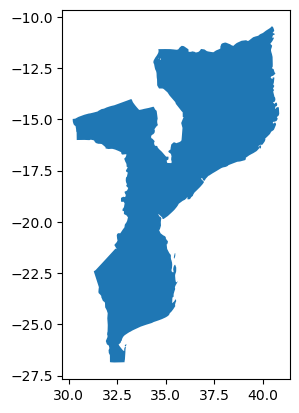

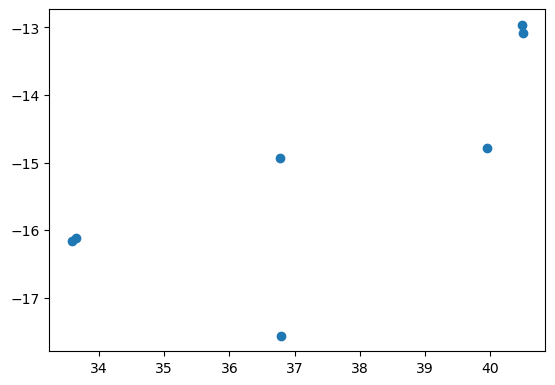

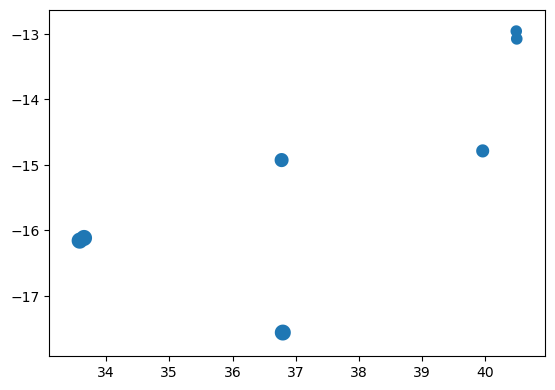

In [32]:
#load shapefiles
projects = gpd.read_file(project_location_path).to_crs(bCRS)
study_area = gpd.read_file(study_area_path).to_crs(bCRS)

#calculate buffer around points/shape
if buffer != 0:
    projects_buf=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_buf['geometry']=projects.to_crs(mCRS).buffer(buffer) #assign the buffer as the new geometry - 
    projects_buf=projects_buf.to_crs(bCRS)#project back to orginal crs

    
#plot shapefiles
study_area.plot()
projects.plot()
projects_buf.plot() 

#show table
projects[[project_id]]

<a id='climate_variables'></a>
# Climate variables

[Home](#beginning_CRVA)

<a id='atmosphere_climate_variables'></a>
# ATMOSPHERE

[Home](#beginning_CRVA)

<a id='worldbank'></a>
## World Bank Climate knowledge portal, Precipitation and Temperature - Atmosphere
data source: https://climateknowledgeportal.worldbank.org/download-data

List of different variables:

### Precipitation 
* return period of current 50 and 100 year event
* yearly average precipitation
* seasonal average precipitation - OR MONTH? i word documnet: average dry season precipitation 
* maximum precipitation in one day - NOT REALLY, instead "Average of the largest daily precipitation amount" rx1day 
* maximum precipitation in five days - NOT REALLY, instead "Average of the largest 5-day consecutive precipitation amount".
* FORSLAG: Could also include: precipitation amount from very wet days/ days >50mm. eg. 

### Temperature
* Yearly mean temperature (average) - tas 
* Number of hot days >40 degrees C (average)
* Number of hot days >35 degrees C (average) 
* Maximum of daily max-temperature (per year) -txx
* Average of maximum temperature (daily??) - tasmax 

### How to use
define 

`variables = {variablename1:{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, variablename2:...}`

where variablename corresponds to a variable name in the cckp, periods include the desired periods, ssps the desired ssp-rcp scenarios, and gcms can be either median, p10, or p90 (50%, 10%, and 90% percentile of ensemble models).

C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\temperature/wb_cckp/anomaly-txx-annual-mean_cmip6_annual_all-regridded-bct-ssp370-climatology_p10_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\temperature/wb_cckp/anomaly-txx-annual-mean_cmip6_annual_all-regridded-bct-ssp370-climatology_p90_2040-2059.nc not found


C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\temperature/wb_cckp/climatology-txx-annual-mean_cmip6_annual_all-regridded-bct-ssp245-climatology_p10_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\temperature/wb_cckp/climatology-txx-annual-mean_cmip6_annual_all-regridded-bct-ssp245-climatology_p90_2040-2059.nc not found


C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\temperature/wb_cckp/climatology-txx-annual-mean_cmip6_annual_all-regridded-bct-ssp370-climatology_p10_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\temperature/wb_cckp/climatology-txx-annual-mean_cmip6_annual_all-regridded-bct-ssp370-climatology_p90_2040-2059.nc not found


C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\temperature/wb_cckp/climatology-tas-annual-mean_cmip6_annual_all-regridded-bct-ssp245-climatology_median_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\temperature/wb_cckp/climatology-tas-annual-mean_cmip6_annual_all-regridded-bct-ssp245-climatology_p10_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\temperature/wb_cckp/climatology-tas-annual-mean_cmip6_annual_all-regridded-bct-ssp245-climatology_p90_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\temperature/wb_cckp/climatology-tas-annual-mean_cmip6_annual_all-regridded-bct-ssp370-climatology_median_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\temperature/wb_cckp/climatology-tas-annual-mean_cmip6_annual_all-regridded-bct-ssp370-climatology_p10_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\temperature/wb_cckp/climatology-tas-annual-mean_cmip6_annual_all-regr

C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/frp100yr-rx1day-period-mean_cmip6_period_all-regridded-bct-ssp370-climatology_p10_2035-2064.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/frp100yr-rx1day-period-mean_cmip6_period_all-regridded-bct-ssp370-climatology_p90_2035-2064.nc not found


C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/frp50yr-rx1day-period-mean_cmip6_period_all-regridded-bct-ssp245-climatology_p10_2010-2039.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/frp50yr-rx1day-period-mean_cmip6_period_all-regridded-bct-ssp245-climatology_p90_2010-2039.nc not found


C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/frp50yr-rx1day-period-mean_cmip6_period_all-regridded-bct-ssp370-climatology_p10_2010-2039.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/frp50yr-rx1day-period-mean_cmip6_period_all-regridded-bct-ssp370-climatology_p90_2010-2039.nc not found


C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-rx5day-annual-mean_cmip6_annual_all-regridded-bct-ssp245-climatology_p10_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-rx5day-annual-mean_cmip6_annual_all-regridded-bct-ssp245-climatology_p90_2040-2059.nc not found


C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-rx5day-annual-mean_cmip6_annual_all-regridded-bct-ssp370-climatology_p10_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-rx5day-annual-mean_cmip6_annual_all-regridded-bct-ssp370-climatology_p90_2040-2059.nc not found


C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-rx1day-annual-mean_cmip6_annual_all-regridded-bct-ssp245-climatology_p10_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-rx1day-annual-mean_cmip6_annual_all-regridded-bct-ssp245-climatology_p90_2040-2059.nc not found


C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-rx1day-annual-mean_cmip6_annual_all-regridded-bct-ssp370-climatology_p10_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-rx1day-annual-mean_cmip6_annual_all-regridded-bct-ssp370-climatology_p90_2040-2059.nc not found


C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasteri

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-pr-monthly-mean_cmip6_monthly_all-regridded-bct-ssp245-climatology_p10_2020-2039.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-pr-monthly-mean_cmip6_monthly_all-regridded-bct-ssp245-climatology_p90_2020-2039.nc not found


C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-pr-monthly-mean_cmip6_monthly_all-regridded-bct-ssp245-climatology_median_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-pr-monthly-mean_cmip6_monthly_all-regridded-bct-ssp245-climatology_p10_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-pr-monthly-mean_cmip6_monthly_all-regridded-bct-ssp245-climatology_p90_2040-2059.nc not found


C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasteri

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-pr-annual-mean_cmip6_annual_all-regridded-bct-ssp245-climatology_p10_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-pr-annual-mean_cmip6_annual_all-regridded-bct-ssp245-climatology_p90_2040-2059.nc not found


C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-pr-annual-mean_cmip6_annual_all-regridded-bct-ssp370-climatology_p10_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-pr-annual-mean_cmip6_annual_all-regridded-bct-ssp370-climatology_p90_2040-2059.nc not found


C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-pr-seasonal-mean_cmip6_seasonal_all-regridded-bct-ssp245-climatology_p10_2020-2039.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-pr-seasonal-mean_cmip6_seasonal_all-regridded-bct-ssp245-climatology_p90_2020-2039.nc not found


C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-pr-seasonal-mean_cmip6_seasonal_all-regridded-bct-ssp370-climatology_p10_2020-2039.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-pr-seasonal-mean_cmip6_seasonal_all-regridded-bct-ssp370-climatology_p90_2020-2039.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-pr-seasonal-mean_cmip6_seasonal_all-regridded-bct-ssp245-climatology_median_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-pr-seasonal-mean_cmip6_seasonal_all-regridded-bct-ssp245-climatology_p10_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-pr-seasonal-mean_cmip6_seasonal_all-regridded-bct-ssp245-climatology_p90_2040-2059.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/climatology-pr-seasonal-m

C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/changefactorfaep100yr-rx1day-period-mean_cmip6_period_all-regridded-bct-ssp245-climatology_p10_2010-2039.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/changefactorfaep100yr-rx1day-period-mean_cmip6_period_all-regridded-bct-ssp245-climatology_p90_2010-2039.nc not found


C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rioxarray\_io.py:1126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\RAPY\Miniconda3\envs\geodata2\lib\site-packages\rasteri

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/changefactorfaep100yr-rx1day-period-mean_cmip6_period_all-regridded-bct-ssp370-climatology_p10_2010-2039.nc not found
\\COWI.net\projects\A245000\A248363\CRVA\Datasets\precipitation/wb_cckp/changefactorfaep100yr-rx1day-period-mean_cmip6_period_all-regridded-bct-ssp370-climatology_p90_2010-2039.nc not found


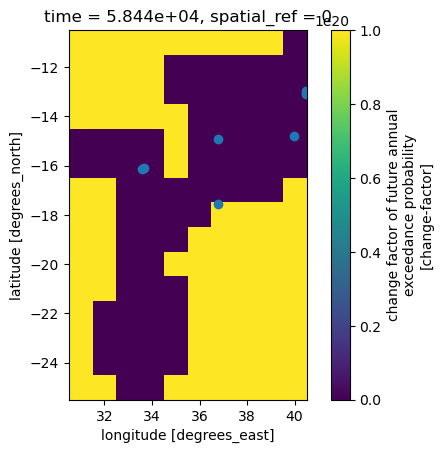

In [33]:
#Read downloaded precipitation and temperature data
#settings

variables= {
    #Temperature
        #era/cru
            #'climatology-hd35-annual-mean_era':{'periods':['1991-2020']},
            'climatology-hd40-annual-mean_era':{'periods':['1991-2020']},
            'climatology-tasmax-annual-mean_era':{'periods':['1991-2020']}, 
            'climatology-tas-annual-mean_era':{'periods':['1991-2020']},
            'climatology-tasmax-annual-mean_cru':{'periods':['1991-2020']}, 
        #realtime
            'climatology-hd40':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'anomaly-hd40':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median']},
            #'anomaly-hd35':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            #'anomaly-tasmax':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, 
            'anomaly-txx':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, #txx=maximum of daily max temperature
            'climatology-txx':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'anomaly-tas':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-tas':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, #data not downloaded 
    #Precipitation
       #era/cru
            #'climatology-r50mm-annual-mean_era_annual':{'periods':['1991-2020']},
            'climatology-rx1day-monthly-mean_era_monthly':{'periods':['1991-2020']},
            'climatology-rx1day-annual-mean_era_annual':{'periods':['1991-2020']},
            'climatology-pr-annual-mean_era_annual':{'periods':['1991-2020']},
            'climatology-pr-monthly-mean_era_monthly':{'periods':['1991-2020']},
            'climatology-pr-annual-mean_cru':{'periods':['1991-2020']},
        #realtime
            'frp100yr-rx1day-period-mean_cmip6_period':{'periods':['2010-2039','2035-2064'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, 
            'frp50yr-rx1day-period-mean_cmip6_period':{'periods':['2010-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-rx5day-annual-mean_cmip6_annual':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-rx1day-annual-mean_cmip6_annual':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-pr-monthly-mean_cmip6_monthly':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-pr-annual-mean_cmip6_annual':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-pr-seasonal-mean_cmip6_seasonal':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'changefactorfaep100yr-rx1day-period-mean_cmip6_period':{'periods':['2010-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            #'anomaly-pr-monthly-mean_cmip6_monthly':{'periods':['2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}
            }
       ## 'timeseries-rx1day':{'periods':['2015-2100'],'ssps':['ssp245'],'gcms':['median']} # Den kan ikke læse den - brokker sig over Dimension time=0. 
       
#Create multi index for cckp_output
idx=pd.IndexSlice
mindex=[]
for var in variables.keys():
    for period in variables[var]['periods']:
        if period in ['1991-2020']:
            mindex.append((var,period,None,None))
        else:
            for ssp in variables[var]['ssps']:
                    for gcm in variables[var]['gcms']:
                        mindex.append((var,period,ssp,gcm))
mindex=pd.MultiIndex.from_tuples(mindex, names=['variable', 'period','ssp','gcm'])
#cckp_output=pd.DataFrame(index=projects[project_id],columns=mindex)
cckp_output=pd.DataFrame(index=mindex,columns=projects[project_id])

#read data from cckp and spatial statistics
for var in variables.keys():
    for period in variables[var]['periods']:
        if period in ['1991-2020']: # for era/cru data
            varname='_'.join((var,period))
            data_path=get_cckp_file_name(var,period=period)
            if os.path.exists(data_path):
                data=read_cckp_ncdata(data_path)
                stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))
                projects[varname]=stats
                #cckp_output.loc[:,idx[var,period,:,:]]=stats.values
                cckp_output.loc[idx[var,period,:,:],:]=stats.T.values
            else:
                print(data_path,"not found")
                projects[varname]='not found'
        elif period not in ['1991-2020']: #for realtime data 
                for ssp in variables[var]['ssps']:
                    for gcm in variables[var]['gcms']:
                        varname='_'.join((var,period,ssp,gcm))
                        data_path=get_cckp_file_name(var,ssp=ssp,period=period,gcm=gcm)
                        if os.path.exists(data_path):
                            data=read_cckp_ncdata(data_path)
                            stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))
                            projects[varname]=stats
                            #cckp_output.loc[:,idx[var,period,ssp,gcm]]=stats.values
                            cckp_output.loc[idx[var,period,ssp,gcm],:]=stats.T.values
                        else:
                            print(data_path,"not found")
                            projects[varname]='not found'
                           

#plot, show #ADD enlarge the clip + something wierd with nodata value
cckp_output.to_csv('outputs/csv/cckp_output.csv')
projects[[project_id,varname]].head()

fig, ax = plt.subplots()
precip = rioxarray.open_rasterio(data)
precip_clip = precip.rio.clip(study_area.geometry, study_area.crs, drop=True)
precip_clip.plot(ax=ax)
projects.plot(ax=ax)

#close
precip.close()
precip_clip.close()

## Wind Speed

Source : https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=form

### Average wind speed
#### Extracting wind datas

In [34]:
### Extraction of Near-surface wind speed data

# Parameters for the copernicus_data function
temporal_resolution = 'daily'
SSP='ssp5_8_5'
model='awi_cm_1_1_mr'
area= [-10, 20, -30,60,] # mozambique area
year_str='2100'
global_variable = 'Wind'
name_variable = 'near_surface_wind_speed'
year_int=int(year_str)

# path were the futur downloaded file is registered
path_for_file= os.path.join(out_path,'Datasets', global_variable, name_variable, SSP, model)

wind_path=copernicus_data(temporal_resolution,SSP,name_variable,model,year_str,area,path_for_file)

2023-03-30 16:06:38,885 INFO Welcome to the CDS
2023-03-30 16:06:38,888 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-03-30 16:06:38,998 INFO Request is completed
2023-03-30 16:06:39,004 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data7/adaptor.esgf_wps.retrieve-1680089856.890472-8370-14-485d1a3b-ee7e-4bae-a873-6468372e6e34.zip to outputs/Downloads\near_surface_wind_speedssp5_8_5awi_cm_1_1_mrdownload.zip (1.4M)
2023-03-30 16:06:40,494 INFO Download rate 958.9K/s                                                                   


PermissionError: [Errno 13] Permission denied

In [ ]:
### register data and statistiques

# register netCDF file 
Wind= Dataset(wind_path)
near_surface_wind_speed = Wind.variables['sfcWind']

# get access to the masked data in the netCDF file
near_surface_wind_speed = ma.getdata(near_surface_wind_speed)
near_surface_wind_speed = near_surface_wind_speed.data

# calculate statistiques over the whole study are for the selected period of the data
data_wind_avg = np.mean(near_surface_wind_speed, axis=0)# compute average
data_wind_med = np.median(near_surface_wind_speed, axis=0)# compute median
data_wind_max = np.max(near_surface_wind_speed, axis=0)# compute max
data_wind_p10 = np.percentile(near_surface_wind_speed,10, axis=0)# compute p10
data_wind_p90 = np.percentile(near_surface_wind_speed,90, axis=0)# compute p90

#### Registering informations concerning wind speed for projects

In [ ]:
### calculation of statistiques concerning the daily wind around each project

# list of statistiques to perform
stats=['mean','median','p10','p90']

# for loop register each operation listed before in the projects DataFrame
for i in range(len(stats)):
    data=read_nc_data(wind_path,stats[i])# converting nc_data to a rater file, type .tif
    name = temporal_resolution+'-'+stats[i]+'-'+global_variable+'-'+year_str+'-'+SSP # create a string to name automatically the column in projects
    # calculation of statistiques concerning the daily wind around each project
    projects[name]=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))# register the value in the dataFrame projects

#### Mapping average wind speed

In [ ]:
### Display Map

# register the unit of the variable printed
unit=Wind.variables['sfcWind'].__dict__['units']

# register and unmask lat and lon
lat = np.ma.getdata(Wind.variables['lat']).data
lon = np.ma.getdata(Wind.variables['lon']).data

# create index for lat and lon
indexes_lat = np.arange(0,len(lat)-1)
indexes_lon = np.arange(0,len(lat)-1)

# parameters for map
title_to_adapt='Average '+temporal_resolution+' wind for '+year_str+' according to '+SSP
label= 'Average '+temporal_resolution+' wind ('+unit+')'
title_png='Mean_near_surface_wind_speed.png'

# function to display the map
Display_map(indexes_lat,indexes_lon,lat,lon,lat_min_wanted,lat_max_wanted,lon_min_wanted,lon_max_wanted,data_wind_avg,title_png,title_to_adapt,label)#,projects)

### Maximum wind speed

In [ ]:
# parameters for map
title_to_adapt='Maximum '+temporal_resolution+' wind for '+year_str+' according to '+SSP
label= 'Maximum '+temporal_resolution+' wind ('+unit+')'
title_png='Max_near_surface_wind_speed.png'

# function to display the map
Display_map(indexes_lat,indexes_lon,lat,lon,lat_min_wanted,lat_max_wanted,lon_min_wanted,lon_max_wanted,data_wind_max,title_png,title_to_adapt,label)#,projects)

## Humidity

### Source : https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=form

### Difference between specific and relative humidity (https://wxresearch.org/specific-humidity-vs-relative-humidity/)

Specific humidity: ratio of the water vapor mass to the total mass of air and water vapor

Relative humidity of air: amount if moisture it contains compared to the maximum amount of moisture it can have at a specific temperature

### Relative humidity, onluy this one appears to be relevant

<a id='land_climate_variables'></a>
# LAND

[Home](#beginning_CRVA)

<a id='landslides'></a>
## Landslides - Land

source: https://datacatalog.worldbank.org/search/dataset/0037584 (Global Landslide Hazard Map, The World Bank)

### Description of LS_TH : 
The Global Landslide Hazard Map presents a qualitative representation of global landslide hazard at a global scale. It is the combination of the The Global Landslide Hazard Map: Median Annual Rainfall-Triggered Landslide Hazard (1980-2018) and The Global Landslide Hazard Map: Earthquake-Triggered Landslide Hazard which has then been simplified to four rank categories, ranging from Very low to High landslide hazard, based on the existing system used by ThinkHazard! (www.thinkhazard.org)

### Description of LS_RF_Median_1980-2018 :
The Global Rainfall-Triggered Landslide Hazard Map presents a quantitative representation of landslide hazard. This component is the median annual rainfall-triggered landslide hazard assessment for the period 1980 – 2018. Raster values represent the modelled average annual frequency of significant rainfall-triggered landslides per sq. km.

In [ ]:

#Landslides data path
landslidesTH_path=os.path.join(data_folder,'landslides/wb_GlLandslHazard/ls_th/LS_TH.tif') ## Global landslide hazard map (TH ranks --> Think hazard ranks)
landslidesRF_path=os.path.join(data_folder,'landslides/wb_GlLandslHazard/ls_rf_median_1980-2018/LS_RF_Median_1980-2018.tif')

#spatial stats
projects['landslides_THmax']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=landslidesTH_path, 
                                                            all_touched=True, stats='max'))
projects['landslidesRF_medianMax']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=landslidesRF_path, 
                                                            all_touched=True, stats='max'))
#show table
projects[[project_id,'landslides_THmax','landslidesRF_medianMax']].head()

#plot landslides TH
fig, ax = plt.subplots()
landslides = rioxarray.open_rasterio(landslidesTH_path)
landslides_clip = landslides.rio.clip(study_area.geometry, study_area.crs, drop=True)
landslides_clip.plot(ax=ax, cmap='Reds',vmin=1, vmax=4)
points=projects.plot(ax=ax,cmap='Greys') # what are those points ????

#close
landslides.close()
landslides_clip.close()

# didn't achieved to present the RF datas
#plot landslides RF
#fig, ax = plt.subplots()
#landslides = rioxarray.open_rasterio(landslidesRF_path)
#landslides_clip = landslides.rio.clip(study_area.geometry, study_area.crs, drop=True)
#landslides_clip.plot(ax=ax, cmap='Reds',vmin=1, vmax=4)
#points=projects.plot(ax=ax,cmap='Greys') # what are those points ????
#landslides.close()


## Global wildfire hazard - Land

This jupyter notebook is to study the global wildfire hazard

Source : https://datacatalog.worldbank.org/search/dataset/0042058/Global-wildfire-hazard

Description of the source : The approach to classify wildfire hazard levels used is based solely on fire weather index climatology. Fire weather indices are used in many countries to assess both the onset of conditions that will allow fires to spread, as well as the likelihood of fire at any point in the landscape. The method presented uses statistical modelling (extreme value analysis) of a 30 year fire weather climatology to assess the predicted fire weather intensity for specific return period intervals. These intensities are classified based on thresholds using conventions to provide hazard classes that correspond to conditions that can support problematic fire spread in the landscape if an ignition and sufficient fuel were to be present.

Date of export : 23.03.23

Projection FWI for europe : https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-tourism-fire-danger-indicators?tab=overview

Projection seasonal severity rating of for EUrope : https://www.eea.europa.eu/data-and-maps/figures/projected-meteorological-forest-fire-danger

Calculation of the FWI : https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi

GLOBAL PROJeTIONS NOT FOUND


## Soil erosion - Land

Source for global actual situations : https://data.jrc.ec.europa.eu/dataset/jrc-esdac-120

<a id='hydrosphere_climate_variables'></a>
# HYDROSPHERE

[Home](#beginning_CRVA)

<a id='floods'></a>
## Floods - Hydrosphere

####  Fluvial
Sources:
1) JRC Flood Hazard Map, http://data.europa.eu/89h/jrc-floods-floodmapgl_rp100y-tif : The map depicts flood prone areas at global scale for flood events with 100-year return period. Resolution is 30 arcseconds (approx. 1km). Cell values indicate water depth (in m). The map can be used to assess flood exposure and risk of population and assets. NOTE: this dataset is based on JRC elaborations and is not an official flood hazard map (for details and limitations please refer to related publications).
2) Dataset of tropical cyclone Idai and subsequent flood disaster in Southern Africa (March 2019). National Tibetan Plateau Data Center, https://data.tpdc.ac.cn/en/data/8d836d13-a8e6-492b-9324-00fbfce40619/ 

#### Coastal 
Source: WRI Aqueduct database

In [ ]:
# save the path for the image presenting the floods which have a return period of a 100 year
flood_path=os.path.join(data_folder,'floodMapGL_rp100y/floodMapGL_rp100y.tif')

buffer_flood=1000#meters # pas sure : sert a avoir les 
if buffer_flood != 0:
    projects_bufFlood=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_bufFlood['geometry']=projects.to_crs(mCRS).buffer(buffer_flood) #assign the buffer as the new geometry - 
    projects_bufFlood=projects_bufFlood.to_crs(bCRS)#project back to orginal crs

projects['floods100yr_max']=pd.DataFrame(zonal_stats(vectors=projects_bufFlood, raster=flood_path, 
                                                            all_touched=True, stats='max'))
#plot
fig, ax = plt.subplots()
floods = rioxarray.open_rasterio(flood_path)
floods_clip = floods.rio.clip(study_area.geometry, study_area.crs, drop=True)
floods_clip.plot(ax=ax,cmap='Blues',vmin=0,vmax=25)
projects.plot(ax=ax,color='Black') # mapping the projects located in the study area
#cb.set_label('Water depth (m)') # name for color scale ne fonctionne pas car cette ligne appartient a basemap language
ax.set_title('Floods extent with a\nreturn period of 100 years') # set a title to the image

#close
floods_clip.close()
floods.close()

#### Sea level rise

Global Mean Sea Level
Source : https://climate.nasa.gov/vital-signs/sea-level/ ; used the Global Mean Sea Level (Global Isostatic Adjustment (GIA) applied) variation (mm) with respect to 20-year TOPEX/Jason collinear mean reference 

Sea Level Trends
Source : https://sealevel.colorado.edu/trend-map : sea level trend from 1992 to 2022

<a id='second_effect_climate_variables'></a>
# Second effect climate variables

[Home](#beginning_CRVA)

<a id='cyclone_risk'></a>
## Cyclones
data source: https://wesr.unepgrid.ch/?project=MX-XVK-HPH-OGN-HVE-GGN&language=en UNEP-GRID, 

cyclone risk level from 1 (low) to 5 (extreme)

In [ ]:
#cyclone data path
cyclone_path=os.path.join(data_folder,'cyclones/unep_grid/cy_risk.tif')
 
   # \\COWI.net\projects\A245000\A248363\CRVA\Datasets\cyclones\unep_grid
#spatial stats
projects['cyclone_risk']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=cyclone_path, all_touched=True, stats='max'))

#show table
projects[[project_id,'cyclone_risk']].head()

#plot
fig, ax = plt.subplots()
cyclone = rioxarray.open_rasterio(cyclone_path)
cyclone_clip = cyclone.rio.clip(study_area.geometry, study_area.crs, drop=True)
cyclone_clip.plot(ax=ax)
projects.plot(ax=ax) # plot the projects on the map

plt.title('Cyclone risk level') # title of the graph

#close
cyclone_clip.close()
cyclone.close()

<a id='climate_change_info_for_each_project_in_study_area'></a>
# Climate change information concerning the projects in the study area

Display climate change information concerning the project you are looking into.

[Home](#beginning_CRVA)

In [ ]:
# selection of projects in the study area
#RAPY: not useful since study area is just for plotting purposes, projects should be only the relevant ones already
#projects_of_interest=projects[projects.within(study_area)]

# selection of the information to display
list_of_names=['Name','province','climatology-hd40_2020-2039_ssp245_median',
               'daily-median-Wind-2100-ssp5_8_5','landslides_THmax','floods100yr_max','cyclone_risk']

# display selected climate change information of the projects in the study area
projects_of_interest_filtered = projects[list_of_names]
projects_of_interest_filtered

# Export
Exports the calculated climate variables to a csv file

[Home](#beginning_CRVA)

In [ ]:
projects.T.to_csv('outputs/csv/projects_climate_risks.csv')